# **Task 2: Identify exogenous variables for forecasting GRACE time series**


---





## **GRACE Data Sorting**

---



**GRACE Data sorting**

In [ ]:
!pip install netCDF4 xarray
from netCDF4 import Dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00


1. Loading the complete GRACE data (Both Land and Ocean datapoints)

In [ ]:
import requests
from netCDF4 import Dataset

# Step 1: Download the data into memory
url = "http://download.csr.utexas.edu/outgoing/grace/RL0602_mascons/CSR_GRACE_GRACE-FO_RL0602_Mascons_all-corrections.nc"
r = requests.get(url, allow_redirects=True, verify=False).content

# Step 2: Define the file path where you want to save the downloaded file
file_path = '/content/grace.nc'

# Step 3: Save the downloaded content to the file
with open(file_path, 'wb') as f:
    f.write(r)
# Step 4: Load the file using netCDF4
grace_data = Dataset(file_path, mode='r')

# Step 5: Verify by printing available variables
print(grace_data.variables.keys())


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'filedrop.csr.utexas.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


dict_keys(['time_bounds', 'time', 'lon', 'lat', 'lwe_thickness'])


2. Load the LandMask data (Used to filter out datapoints for Land sample sites later)

In [ ]:
url = "https://download.csr.utexas.edu/outgoing/grace/RL0602_mascons/CSR_GRACE_GRACE-FO_RL06_Mascons_v02_LandMask.nc"
r = requests.get(url, allow_redirects=True, verify=False).content

file_path = '/content/land.nc'

with open(file_path, 'wb') as f:
    f.write(r)

land_data = Dataset(file_path, mode='r')

print(grace_data.variables.keys())


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.csr.utexas.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


dict_keys(['time_bounds', 'time', 'lon', 'lat', 'lwe_thickness'])


3. Filter Ocean from GRACE data to remain Land datapoints


*   Compare full GRACE data array with LandMask
*   Identify common ID as geolocation points (Lat and Lon)
*   Filter out points not common to both arrays
*   Deliverable/Output = GRACE dataset with only Land datapoints



In [ ]:
#Install necessary libraries
!pip install pyarrow plotly cftime

import netCDF4
import numpy as np
import pandas as pd
import xarray as xr
import plotly.express as px
import cftime

# Load the GRACE data using xarray
ds = xr.open_dataset("/content/grace.nc")
land_mask_ds = xr.open_dataset("/content/land.nc")

# Extract key variables
lat = ds['lat'].values
lon = ds['lon'].values
time = ds['time'].values
lwe_thickness = ds['lwe_thickness'].values

# Handle the time variable
if 'units' in ds['time'].attrs:
    time_units = ds['time'].attrs['units']
    time_calendar = ds['time'].attrs.get('calendar', 'standard')
    time_converted = xr.cftime_range(start=pd.to_datetime("2002-01-01"), periods=len(time), freq='MS')
else:
    # Manually define time if 'units' is missing
    print("Time units not found. Defining time manually.")
    time_converted = pd.date_range(start='2002-01-01', periods=len(time), freq='MS')

# Extract the land mask data
land_mask_data = land_mask_ds['LO_val'].values

# Ensure dimensions match
print("LWE thickness dimensions:", lwe_thickness.shape)
print("Land mask dimensions:", land_mask_data.shape)

# Reshape or transpose land_mask_data if necessary
if land_mask_data.shape != lwe_thickness.shape[1:]:
    land_mask_data = land_mask_data.T

# Expand land_mask_data to match the time dimension
time_dim = lwe_thickness.shape[0]
land_mask_3d = np.broadcast_to(land_mask_data[np.newaxis, :, :], (time_dim, lat.size, lon.size))

# Apply the land mask
lwe_land = lwe_thickness * land_mask_3d
lwe_land[land_mask_3d == 0] = np.nan

# Clean up
del land_mask_3d
del lwe_thickness

# Create xarray DataArray
lwe_land_da = xr.DataArray(
    lwe_land,
    dims=('time', 'lat', 'lon'),
    coords={'time': time_converted, 'lat': lat, 'lon': lon}
)

# Convert to DataFrame
lwe_data = lwe_land_da.to_dataframe(name='LWE_Thickness').reset_index()

# Remove NaN values
lwe_data.dropna(subset=['LWE_Thickness'], inplace=True)

# Clean up
del lwe_land_da
del lwe_land

# Write the full data to a Parquet file
lwe_data.to_parquet('lwe_data_df.parquet')


Time units not found. Defining time manually.
LWE thickness dimensions: (233, 720, 1440)
Land mask dimensions: (720, 1440)
Sampled data size: 851209


# **Exogenous Variables Sorting**

---



1. Load the datafile for possible exogenous variables, provided from ERA5 monthly averaged data on single levels from 1940 to present
(https://doi.org/10.24381/cds.f17050d7)

In [ ]:
#Load the whole data to session
!wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache/aece9f00f6adbdadf2ff59cf5369aca.zip


--2024-09-17 13:40:09--  https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache/aece9f00f6adbdadf2ff59cf5369aca.zip
Resolving object-store.os-api.cci2.ecmwf.int (object-store.os-api.cci2.ecmwf.int)... 136.156.136.3
Connecting to object-store.os-api.cci2.ecmwf.int (object-store.os-api.cci2.ecmwf.int)|136.156.136.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8478930409 (7.9G) [application/zip]
Saving to: ‘aece9f00f6adbdadf2ff59cf5369aca.zip’

aece9f00f6adbdadf2f 100%[===================>]   7.90G  2.11MB/s    in 25m 45s 

2024-09-17 14:05:54 (5.23 MB/s) - ‘aece9f00f6adbdadf2ff59cf5369aca.zip’ saved [8478930409/8478930409]



2. Unzip Content to memory

In [ ]:
#unzip content
!unzip aece9f00f6adbdadf2ff59cf5369aca.zip -d /content/eras

Archive:  aece9f00f6adbdadf2ff59cf5369aca.zip
  inflating: /content/eras/data_0.nc  
  inflating: /content/eras/data_1.nc  
  inflating: /content/eras/data_2.nc  
  inflating: /content/eras/data_3.nc  


3. Check Exogenous variables provided in the ERA5 data:


*   Data contains 10 exogenous variables used for this analysis.
*   Datafile 1 and 2 are replicates of the same content, hence, one was used in the long-run.


In [ ]:
eras_0 = '/content/eras/data_0.nc'
eras_1 = '/content/eras/data_1.nc'
eras_2 = '/content/eras/data_2.nc'
eras_3 = '/content/eras/data_3.nc'

eras_data_0 = Dataset(eras_0, mode='r')
eras_data_1 = Dataset(eras_1, mode='r')
eras_data_2 = Dataset(eras_2, mode='r')
eras_data_3 = Dataset(eras_3, mode='r')

# Check the variables available
print(eras_data_0.variables.keys(), ("\n"),
      eras_data_1.variables.keys(), ("\n"),
      eras_data_2.variables.keys(), ("\n"),
      eras_data_3.variables.keys())


dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 'swvl4']) 
 dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 'sro', 'smlt', 'sf', 'e', 'tp']) 
 dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 'sro', 'smlt', 'sf', 'e', 'tp']) 
 dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 'lai_lv', 'lai_hv', 't2m', 'src'])


4. Verify array dimension

In [ ]:
import xarray as xr

# Load a sample dataset
eras_1 = xr.open_dataset('/content/eras/data_1.nc')

# Print the dataset's dimensions
print(eras_1.dims)

Frozen({'valid_time': 266, 'latitude': 1801, 'longitude': 3600})


# **Data Merging - GRACE and ERA5**

*   Merge Exogenous variables in ERA5 to the GRACE Land data points to append exogenous variables to LWE_Thickness (This is a measure used in hydrology and remote sensing to quantify the amount of water stored in the form of snow, ice, or groundwater)
*   Common IDs will be the coordinate data (lat and lon) to both datasets
*   Due to RAM limits, merging of the ERA5 fragmented data was conducted in 2 splits:
1. GRACE and ERA5 data 0 & 3
2. GRACE and ERA5 data 1


---




1. **GRACE and ERA5 data 0 & 3**

In [ ]:
#Merge unique exogenous variables of the ERA5 0 & 3 with GRACE, using coord as matching ID
import xarray as xr
import pandas as pd
import numpy as np

# Load the GRACE Land LWE thickness data from the Parquet file
lwe_land_df = pd.read_parquet('/content/lwe_data_df.parquet')

# Convert the LWE DataFrame to an xarray Dataset
lwe_land_da = lwe_land_df.set_index(['time', 'lat', 'lon']).to_xarray()['LWE_Thickness']

# Load datasets
eras_0 = xr.open_dataset('/content/eras/data_0.nc')
eras_3 = xr.open_dataset('/content/eras/data_3.nc')

# Select unique variables from each dataset
variables_0 = ['swvl4']
variables_3 = ['lai_lv', 'lai_hv', 't2m', 'src']

# Extract the selected variables from each dataset
ds_0 = eras_0[variables_0]
ds_3 = eras_3[variables_3]

# Combine the datasets into one dataset, ensuring they share the same time, lat, lon
# First, align all datasets by time, lat, and lon
ds_combined = xr.merge([ds_0, ds_3])

# Rename the coordinates
ds_combined = ds_combined.rename({'valid_time': 'time', 'latitude': 'lat', 'longitude': 'lon'})

# Align time coordinates by reindexing with LWE data
ds_combined_aligned = ds_combined.reindex(time=lwe_land_da.time, method='nearest')

# Check if lat/lon grids need interpolation
if not (np.array_equal(ds_combined_aligned['lat'], lwe_land_da['lat']) and np.array_equal(ds_combined_aligned['lon'], lwe_land_da['lon'])):
    print("Interpolating combined ERA data to match LWE land data grid...")

    # Interpolate combined ERA data to match LWE land data grid
    ds_interp = ds_combined_aligned.interp(lat=lwe_land_da['lat'], lon=lwe_land_da['lon'], method="linear")
else:
    ds_interp = ds_combined_aligned  # No interpolation needed if grids match

# Combine the interpolated ERA dataset with LWE land data
combined_ds = xr.Dataset({
    'LWE_Thickness': lwe_land_da,
    **{var: ds_interp[var] for var in ds_interp}
})

# Convert to a DataFrame for further analysis
combined_df = combined_ds.to_dataframe().reset_index()

# Remove NaN values that may have resulted from interpolation
combined_df.dropna(inplace=True)

# Display the combined DataFrame
print(combined_df.tail(100))

# Export the combined DataFrame to Parquet
output_path = '/content/eras_0&3_data.parquet'
combined_df.to_parquet(output_path, index=False)

Interpolating combined ERA data to match LWE land data grid...
                time     lat      lon  LWE_Thickness     swvl4  lai_lv  \
222782228 2021-05-01  83.125  317.125    -152.555573  0.281334     0.0   
222782229 2021-05-01  83.125  317.375    -152.555573  0.290728     0.0   
222782230 2021-05-01  83.125  317.625    -152.555573  0.302147     0.0   
222782231 2021-05-01  83.125  317.875    -152.555573  0.308219     0.0   
222782232 2021-05-01  83.125  318.125    -152.555573  0.297495     0.0   
...              ...     ...      ...            ...       ...     ...   
222783726 2021-05-01  83.375  331.625     -10.545981  0.330157     0.0   
222783727 2021-05-01  83.375  331.875     -10.545981  0.332154     0.0   
222783728 2021-05-01  83.375  332.125     -10.545981  0.334359     0.0   
222783729 2021-05-01  83.375  332.375     -10.545981  0.336694     0.0   
222783730 2021-05-01  83.375  332.625     -10.545981  0.341200     0.0   

           lai_hv         t2m           src  
22

2. GRACE and ERA5 data 1

In [ ]:
#Merge unique exogenous variables of the data 1 ERA5 with grace, using coord as matching ID
import xarray as xr
import pandas as pd
import numpy as np

lwe_land_df = pd.read_parquet('/content/lwe_data_df.parquet')

lwe_land_da = lwe_land_df.set_index(['time', 'lat', 'lon']).to_xarray()['LWE_Thickness']

eras_1 = xr.open_dataset('/content/eras/data_1.nc')

variables_1 = ['sro', 'smlt', 'sf', 'e', 'tp']
ds_1 = eras_1[variables_1]
ds_1 = ds_1.rename({'valid_time': 'time', 'latitude': 'lat', 'longitude': 'lon'})

ds_1_aligned = ds_1.reindex(time=lwe_land_da.time, method='nearest')

if not (np.array_equal(ds_1_aligned['lat'], lwe_land_da['lat']) and np.array_equal(ds_1_aligned['lon'], lwe_land_da['lon'])):
    print("Interpolating ERA data to match LWE land data grid...")

    # Interpolate ERA data to match LWE land data grid
    ds_interp = ds_1_aligned.interp(lat=lwe_land_da['lat'], lon=lwe_land_da['lon'], method="linear")
else:
    ds_interp = ds_1_aligned  # No interpolation needed if grids match

combined_ds = xr.Dataset({
    'LWE_Thickness': lwe_land_da,
    **{var: ds_interp[var] for var in ds_interp}
})

combined_df = combined_ds.to_dataframe().reset_index()
combined_df.dropna(inplace=True)

print(combined_df.tail(100))

output_path = '/content/eras_1_data.parquet'
combined_df.to_parquet(output_path, index=False)

Interpolating ERA data to match LWE land data grid...
                time     lat      lon  LWE_Thickness           sro      smlt  \
222782228 2021-05-01  83.125  317.125    -152.555573  1.350418e-08  0.000000   
222782229 2021-05-01  83.125  317.375    -152.555573  9.715557e-06  0.000010   
222782230 2021-05-01  83.125  317.625    -152.555573  2.722535e-05  0.000027   
222782231 2021-05-01  83.125  317.875    -152.555573  5.661603e-05  0.000057   
222782232 2021-05-01  83.125  318.125    -152.555573  1.180470e-04  0.000118   
...              ...     ...      ...            ...           ...       ...   
222783726 2021-05-01  83.375  331.625     -10.545981  1.396984e-09  0.000000   
222783727 2021-05-01  83.375  331.875     -10.545981  9.778887e-09  0.000000   
222783728 2021-05-01  83.375  332.125     -10.545981  1.676381e-08  0.000000   
222783729 2021-05-01  83.375  332.375     -10.545981  2.235174e-08  0.000000   
222783730 2021-05-01  83.375  332.625     -10.545981  2.235174e-08

3. Converting GRACE land data to parquet format for filtering of Ocean data points from ERA5

This action reduces duplication of exogenous variables across coordinates for Ocean point in the ERA5 data. Thereby reducing data from over 220million different ERA5 reports to 80+ million, equally representative for Land coordinates present on the filtered GRACE data

In [ ]:
#Convert landmask to parquet
ds = xr.open_dataset('/content/land.nc')

# Convert the xarray Dataset to a pandas DataFrame
df = ds.to_dataframe().reset_index()

# Export the DataFrame to a Parquet file
output_path = '/content/land.parquet'
df.to_parquet(output_path, index=False)



*   Filter for 1st Batch of ERA5 data



In [ ]:
#Filter out ocean mask from 1st ERA5
import pandas as pd

# Load the ERA data
era_df = pd.read_parquet('/content/eras_1_data.parquet')

# Load the land mask data
land_mask_df = pd.read_parquet('/content/land.parquet')

# Extract unique latitude and longitude pairs from the land mask DataFrame
land_mask_lat_lon = land_mask_df[['lat', 'lon']].drop_duplicates()

# Filter the ERA DataFrame based on latitude and longitude pairs present in the land mask
filtered_era_df = era_df.merge(land_mask_lat_lon, on=['lat', 'lon'], how='inner')

# Remove NaN values that may have resulted from filtering
filtered_era_df.dropna(inplace=True)

# Display the filtered DataFrame
print(filtered_era_df.tail(100))

# Export the filtered DataFrame to a Parquet file
output_path = '/content/filt_ERA5_1.parquet'
filtered_era_df.to_parquet(output_path, index=False)


               time     lat      lon  LWE_Thickness           sro  smlt  \
80510487 2013-02-01  83.375  332.625     -23.143089  1.536682e-08   0.0   
80510488 2013-03-01  83.375  332.625     -10.767025  1.536682e-08   0.0   
80510489 2013-04-01  83.375  332.625       3.954122  1.536682e-08   0.0   
80510490 2013-05-01  83.375  332.625      20.511606  2.235174e-08   0.0   
80510491 2013-06-01  83.375  332.625      17.533304  2.612360e-07   0.0   
...             ...     ...      ...            ...           ...   ...   
80510582 2021-01-01  83.375  332.625     -14.300250  2.235174e-08   0.0   
80510583 2021-02-01  83.375  332.625     -41.299538  1.676381e-08   0.0   
80510584 2021-03-01  83.375  332.625     -36.068890  2.235174e-08   0.0   
80510585 2021-04-01  83.375  332.625      -6.707384  1.536682e-08   0.0   
80510586 2021-05-01  83.375  332.625     -10.545981  2.235174e-08   0.0   

                sf         e        tp  
80510487  0.000173  0.000013  0.000176  
80510488  0.00038



*   Filter for 2nd Batch of ERA5 data



In [ ]:
#Filter out ocean mask from 2nd ERA5

era_df = pd.read_parquet('/content/eras_0&3_data.parquet')

land_mask_df = pd.read_parquet('/content/land.parquet')

land_mask_lat_lon = land_mask_df[['lat', 'lon']].drop_duplicates()

filtered_era_df = era_df.merge(land_mask_lat_lon, on=['lat', 'lon'], how='inner')

filtered_era_df.dropna(inplace=True)

print(filtered_era_df.tail(100))

output_path = '/content/filt_ERA5_0&3.parquet'
filtered_era_df.to_parquet(output_path, index=False)


               time     lat      lon  LWE_Thickness   swvl4  lai_lv  lai_hv  \
80510487 2013-02-01  83.375  332.625     -23.143089  0.3412     0.0     0.0   
80510488 2013-03-01  83.375  332.625     -10.767025  0.3412     0.0     0.0   
80510489 2013-04-01  83.375  332.625       3.954122  0.3412     0.0     0.0   
80510490 2013-05-01  83.375  332.625      20.511606  0.3412     0.0     0.0   
80510491 2013-06-01  83.375  332.625      17.533304  0.3412     0.0     0.0   
...             ...     ...      ...            ...     ...     ...     ...   
80510582 2021-01-01  83.375  332.625     -14.300250  0.3412     0.0     0.0   
80510583 2021-02-01  83.375  332.625     -41.299538  0.3412     0.0     0.0   
80510584 2021-03-01  83.375  332.625     -36.068890  0.3412     0.0     0.0   
80510585 2021-04-01  83.375  332.625      -6.707384  0.3412     0.0     0.0   
80510586 2021-05-01  83.375  332.625     -10.545981  0.3412     0.0     0.0   

                 t2m           src  
80510487  239.

4. Merge both GRACE-ERA5 0&3 with GRACE-ERA5 1 together

*   Common ID used was the coordinate and LWE_Thickness values, which are similar across both dataset
*   NB: Data Split was initially necessary due to limited RAM usage



In [ ]:
#merge parquet file together
import pandas as pd

# Load the two Parquet files into DataFrames
df1 = pd.read_parquet('/content/filt_ERA5_1.parquet')
df2 = pd.read_parquet('/content/filt_ERA5_0&3.parquet')

# Merge the two DataFrames on common columns
merged_df = pd.merge(df1, df2, on=['time', 'lat', 'lon', 'LWE_Thickness'], how='outer')

# Export the merged DataFrame to a new Parquet file
output_path = '/content/merged_ERA5.parquet'
merged_df.to_parquet(output_path, index=False)

Merged data has been successfully exported to /content/merged_ERA5.parquet


# **Data Visualisation**

---



1. Data Loading

In [7]:
import pandas as pd

file_path = '/content/merged_ERA5.parquet'

df = pd.read_parquet(file_path)

# Convert 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

df.tail()

,time,lat,lon,LWE_Thickness,sro,smlt,sf,e,tp,swvl4,lai_lv,lai_hv,t2m,src
80510582,2021-01-01,83.375,332.625,-14.300250,2.235174e-08,0.0,0.000441,0.000028,0.000446,0.3412,0.0,0.0,248.104401,3.725290e-09
80510583,2021-02-01,83.375,332.625,-41.299538,1.676381e-08,0.0,0.000284,0.000027,0.000287,0.3412,0.0,0.0,246.679382,3.725290e-09
80510584,2021-03-01,83.375,332.625,-36.068890,2.235174e-08,0.0,0.000455,0.000025,0.000459,0.3412,0.0,0.0,243.644836,3.725290e-09
80510585,2021-04-01,83.375,332.625,-6.707384,1.536682e-08,0.0,0.000248,0.000025,0.000250,0.3412,0.0,0.0,250.729996,3.725290e-09
80510586,2021-05-01,83.375,332.625,-10.545981,2.235174e-08,0.0,0.000213,0.000005,0.000217,0.3412,0.0,0.0,260.972839,3.725290e-09


2. Plot Correlation Matrix of all available variables

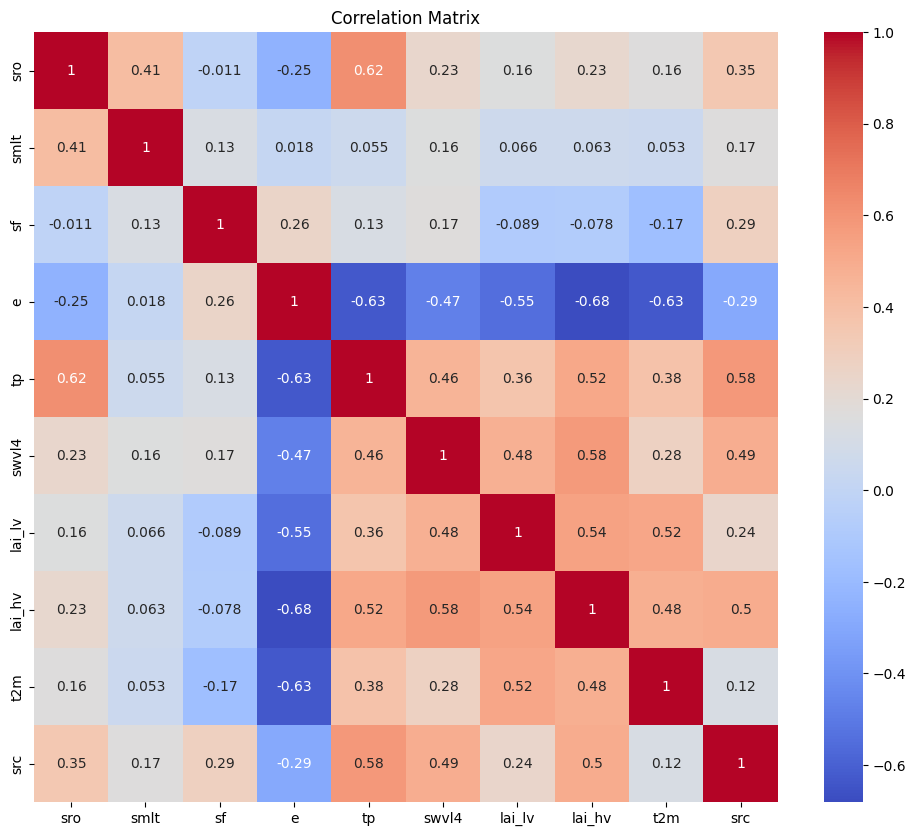

In [13]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# List of features to scale
features_to_scale = ['sro', 'smlt', 'sf', 'e', 'tp', 'swvl4', 'lai_lv', 'lai_hv', 't2m', 'src']

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Calculate correlation matrix
corr_matrix = df[features_to_scale].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix across exogenous variables')
plt.show()

3. Data Subsetting

*   Due to limited compute power, we worked with multiple 1% of the dataset by changing the random_state values for each model iteration (hence, a batch of 5 data with shape (805105,14)).
*   We used random_state=42, 37, 7, 123, 99

Random Forest Accuracy Metrics (RS=42):
Mean Squared Error: 1099.56
Mean Absolute Error: 12.49
R-squared: 0.81

Random Forest Accuracy Metrics (RS=37):
Mean Squared Error: 1146.42
Mean Absolute Error: 12.61
R-squared: 0.81

Random Forest Accuracy Metrics(RS=7):
Mean Squared Error: 1238.05
Mean Absolute Error: 12.89
R-squared: 0.80

Random Forest Accuracy Metrics (RS=123):
Mean Squared Error: 1115.73
Mean Absolute Error: 12.70
R-squared: 0.82

Random Forest Accuracy Metrics (RS=99):
Mean Squared Error: 1199.74
Mean Absolute Error: 12.86
R-squared: 0.80

In [8]:
# Sample multiple (5) 1% of the data
df = df.sample(frac=0.01, random_state=99)
df = df.reset_index(drop=True)
# df.shape
df.tail(10)

,time,lat,lon,LWE_Thickness,sro,smlt,sf,e,tp,swvl4,lai_lv,lai_hv,t2m,src
805096,2019-07-01,26.875,254.375,-18.125359,4.038215e-06,0.000000,0.000000,-0.001104,0.001047,0.168900,1.009926,0.093872,297.861023,1.781713e-05
805097,2008-07-01,-76.125,298.875,2.898634,0.000000e+00,0.000000,0.000509,0.000024,0.000512,0.108237,0.000000,0.000000,244.559006,2.000034e-04
805098,2009-10-01,72.875,108.125,-0.903558,1.006783e-05,0.000172,0.000348,-0.000039,0.000708,0.375341,0.819824,0.000000,264.779541,5.370472e-05
805099,2017-12-01,-22.375,303.375,20.590153,1.720968e-03,0.000000,0.000000,-0.004386,0.009025,0.301620,2.102890,3.140450,299.937378,1.949295e-04
805100,2004-03-01,-89.375,64.375,-1.775512,0.000000e+00,0.000000,0.000112,0.000012,0.000116,0.144913,0.000000,0.000000,226.365219,-3.241724e-20
805101,2007-12-01,76.625,239.625,3.724533,0.000000e+00,0.000000,0.000201,0.000026,0.000207,0.367159,0.511429,0.000000,245.578705,1.792796e-05
805102,2004-03-01,-21.875,124.625,12.379883,1.695473e-06,0.000000,0.000000,-0.002162,0.000543,0.090682,1.213112,0.000000,302.084595,9.291805e-06
805103,2009-08-01,55.125,238.375,-1.293267,1.269719e-05,0.000000,0.000000,-0.002051,0.001650,0.319497,0.000000,2.902443,285.015930,6.869994e-05
805104,2004-04-01,43.625,83.375,6.864974,8.889248e-04,0.004435,0.000385,-0.000810,0.002116,0.368377,0.498535,1.873299,277.094421,2.204869e-04
805105,2012-03-01,43.125,90.125,-1.961769,9.811483e-07,0.000158,0.000156,-0.000235,0.000217,0.116049,0.455170,0.000000,278.737366,9.126961e-08


4. Plotting Data Distribution visualisation over time

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.figure(figsize=(15, 5))

mpl.rcParams['agg.path.chunksize'] = 100000

plt.plot(df['time'], df['LWE_Thickness'], label='LWE_Thickness')
plt.title('LWE_Thickness over Time')
plt.xlabel('Time')
plt.ylabel('LWE_Thickness')
plt.legend()
plt.show()

# **Multiple Model Trainings**

Multiple models were trained with data from the onset of the GRACE data and tested to forecast the Liquid Water Equivalent (LWE) Thickness for the last 5 years.
the 10 Exogenous variables were inputed as variables for prediction.

> Mean Squared Error, Mean Absolute Error, and R-squared values were appropriate metric selected to evaluate accuracy of models


*   Model 1 - Random Forest Model
*   Model 2 - XG-Boost Regressor Model
*   Model 3 - CatBoost Regressor Model
*   Model 4 - Decision Tree Regressor Model
*   Model 5 - Dynamic generalised additive Model


---






## Model 1 - RandomForest Regressor Model


Random Forest Accuracy Metrics:
Mean Squared Error: 1199.7434957886676
Mean Absolute Error: 12.861373963522388
R-squared: 0.8038981564605108


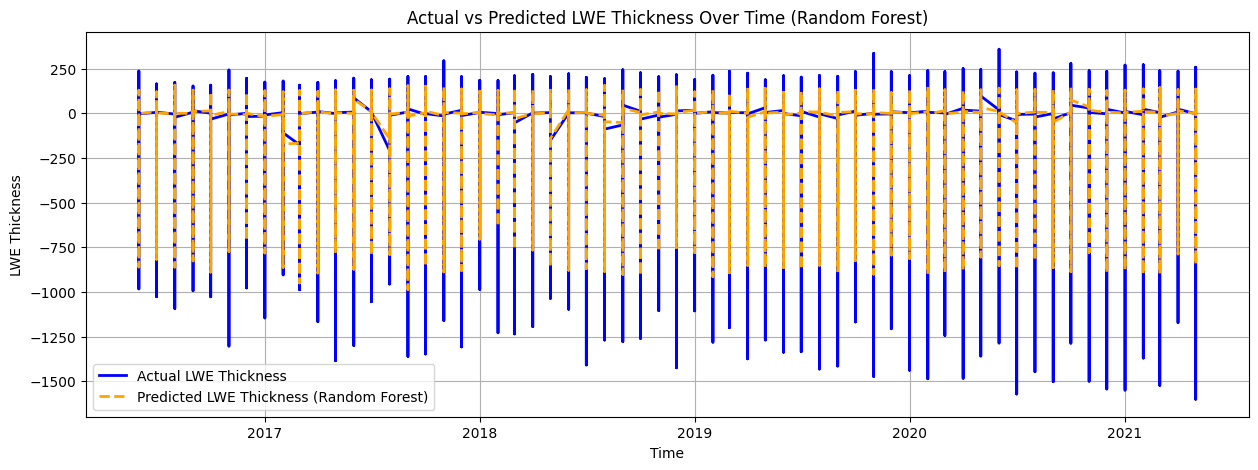

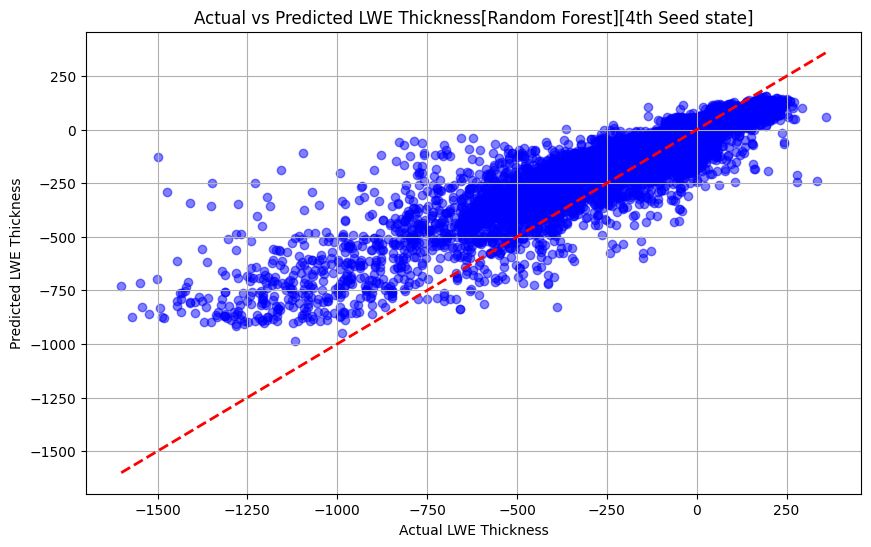

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Set the inception date
inception_date = df['time'].min()

# Define a function to calculate months since inception
def months_since_inception(date, inception_date):
    return (date.year - inception_date.year) * 12 + (date.month - inception_date.month)

# Apply the function to the 'time' column
df['months_since_inception'] = df['time'].apply(lambda x: months_since_inception(x, inception_date))

# Sort the DataFrame by time
df = df.sort_values(by='time')

# Determine the last date in the data
last_date = df['time'].max()

# Get the date that is 5 years before the last date
five_years_before_last = last_date - pd.DateOffset(years=5)

# Split the data into training
df_train = df[df['time'] <= five_years_before_last]
df_test = df[df['time'] > five_years_before_last]

# Define features and target variable for training and testing
features = ['months_since_inception', 'lat', 'lon', 'sro', 'smlt', 'sf', 'e', 'tp', 'swvl4', 'lai_lv', 'lai_hv', 't2m', 'src']
X_train = df_train[features]
y_train = df_train['LWE_Thickness']

X_test = df_test[features]
y_test = df_test['LWE_Thickness']

# Initialize and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_rf = rf_model.predict(X_test)

# Evaluate model performance
mse_rf = mean_squared_error(y_test, predictions_rf)
mae_rf = mean_absolute_error(y_test, predictions_rf)
r2_rf = r2_score(y_test, predictions_rf)

# Print accuracy metrics
print("\nRandom Forest Accuracy Metrics:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R-squared: {r2_rf}")

# Create a DataFrame to compare expected vs predicted values
results_rf = pd.DataFrame({
    'time': df_test['time'].values,
    'expected': y_test.values,
    'predicted': predictions_rf
})

# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(results_rf['time'], results_rf['expected'], label='Actual LWE Thickness', color='blue', linewidth=2)
plt.plot(results_rf['time'], results_rf['predicted'], label='Predicted LWE Thickness (Random Forest)', color='orange', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Actual vs Predicted LWE Thickness Over Time (Random Forest)')
plt.xlabel('Time')
plt.ylabel('LWE Thickness')
plt.legend()
plt.grid()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_rf, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual LWE Thickness')
plt.ylabel('Predicted LWE Thickness')
plt.title('Actual vs Predicted LWE Thickness[Random Forest][4th Seed state]')
plt.grid()
plt.show()


*   Feature Importance [Random Forest Model]

  Feature  Importance
5   swvl4    0.111015
2      sf    0.033670
9     src    0.028882
3       e    0.023078
7  lai_hv    0.016770
8     t2m    0.016121
4      tp    0.014291
6  lai_lv    0.008950
0     sro    0.005762
1    smlt    0.002929


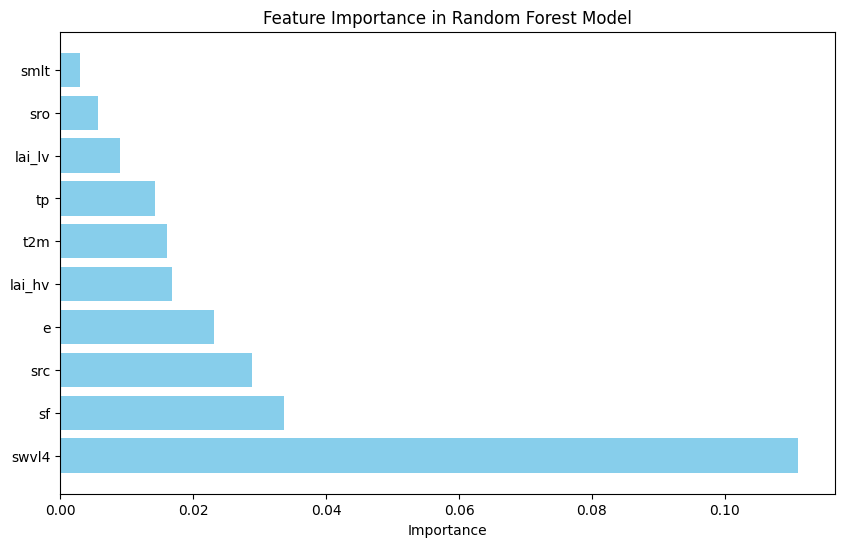

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Specify the features to exclude
exclude_features = ['lat', 'lon', 'months_since_inception']

# Filter out the excluded features
filtered_features = [feature for feature in features if feature not in exclude_features]

# Calculate feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for feature importance excluding the specified features
feature_importance_df = pd.DataFrame({
    'Feature': filtered_features,
    'Importance': importances[[features.index(feature) for feature in filtered_features]]
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()


## Model 2 - XG-Boost Regressor Model


XGBoost Accuracy Metrics:
Mean Squared Error: 1504.51220703125
Mean Absolute Error: 16.072126388549805
R-squared: 0.7516522128073396


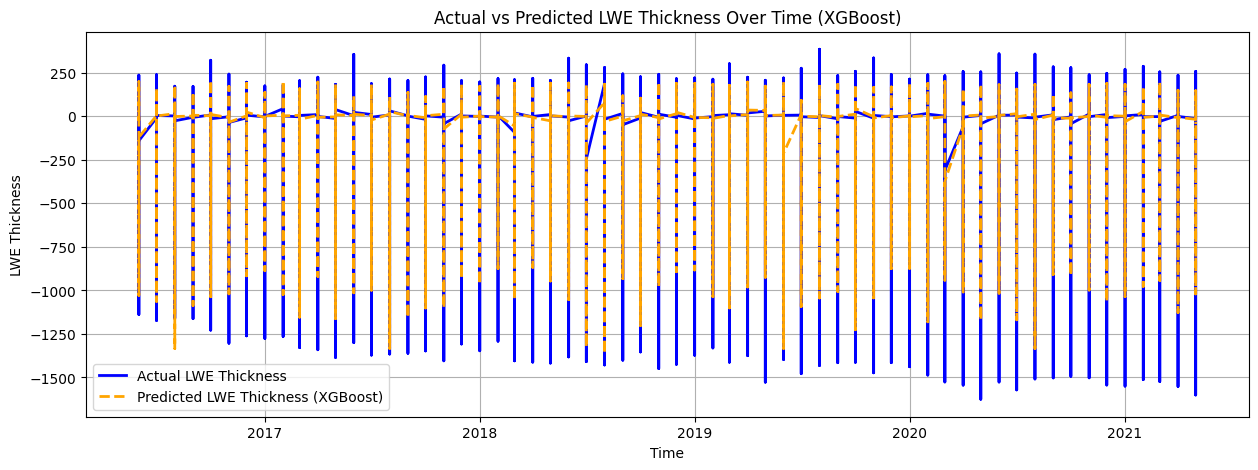

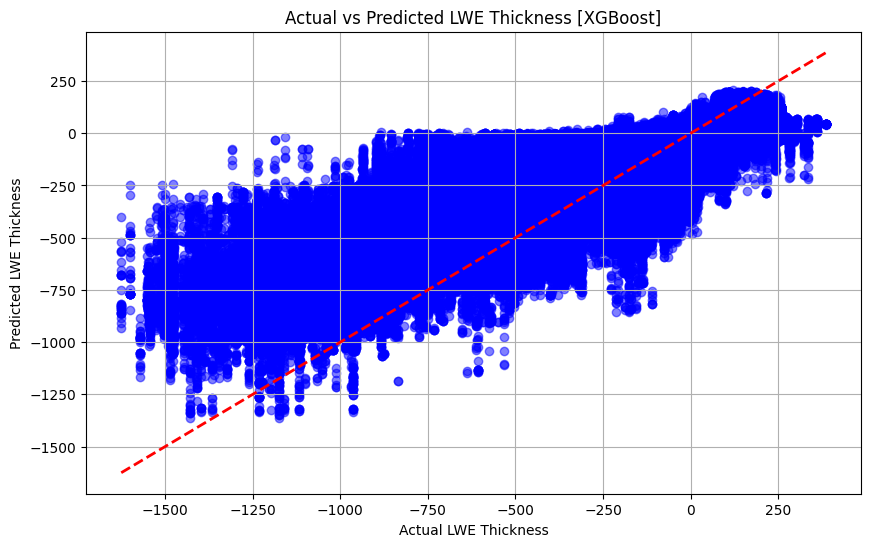

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Set the inception date
inception_date = df['time'].min()

# Define a function to calculate months since inception
def months_since_inception(date, inception_date):
    return (date.year - inception_date.year) * 12 + (date.month - inception_date.month)

# Apply the function to the 'time' column
df['months_since_inception'] = df['time'].apply(lambda x: months_since_inception(x, inception_date))

# Sort the DataFrame by time
df = df.sort_values(by='time')

# Determine the last date in the data
last_date = df['time'].max()

# Get the date that is 5 years before the last date
five_years_before_last = last_date - pd.DateOffset(years=5)

# Split the data into training
df_train = df[df['time'] <= five_years_before_last]
df_test = df[df['time'] > five_years_before_last]

# Define features and target variable for training and testing
features = ['months_since_inception', 'lat', 'lon','sro', 'smlt', 'sf', 'e', 'tp', 'swvl4', 'lai_lv', 'lai_hv', 't2m', 'src']
X_train = df_train[features]
y_train = df_train['LWE_Thickness']

X_test = df_test[features]
y_test = df_test['LWE_Thickness']

# Initialize and fit the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_xgb = xgb_model.predict(X_test)

# Evaluate model performance
mse_xgb = mean_squared_error(y_test, predictions_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
r2_xgb = r2_score(y_test, predictions_xgb)

# Print accuracy metrics
print("\nXGBoost Accuracy Metrics:")
print(f"Mean Squared Error: {mse_xgb}")
print(f"Mean Absolute Error: {mae_xgb}")
print(f"R-squared: {r2_xgb}")

# Create a DataFrame to compare expected vs predicted values
results_xgb = pd.DataFrame({
    'time': df_test['time'].values,
    'expected': y_test.values,
    'predicted': predictions_xgb
})

# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(results_xgb['time'], results_xgb['expected'], label='Actual LWE Thickness', color='blue', linewidth=2)
plt.plot(results_xgb['time'], results_xgb['predicted'], label='Predicted LWE Thickness (XGBoost)', color='orange', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Actual vs Predicted LWE Thickness Over Time (XGBoost)')
plt.xlabel('Time')
plt.ylabel('LWE Thickness')
plt.legend()
plt.grid()
plt.show()

# Plot actual vs predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_xgb, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual LWE Thickness')
plt.ylabel('Predicted LWE Thickness')
plt.title('Actual vs Predicted LWE Thickness [XGBoost]')
plt.grid()
plt.show()


*   Feature Importance [XGBoost Model]

  Feature  Importance
7  lai_hv    0.170335
5   swvl4    0.166332
2      sf    0.095639
1    smlt    0.067023
0     sro    0.037971
9     src    0.034260
6  lai_lv    0.030636
3       e    0.020927
8     t2m    0.011814
4      tp    0.011505


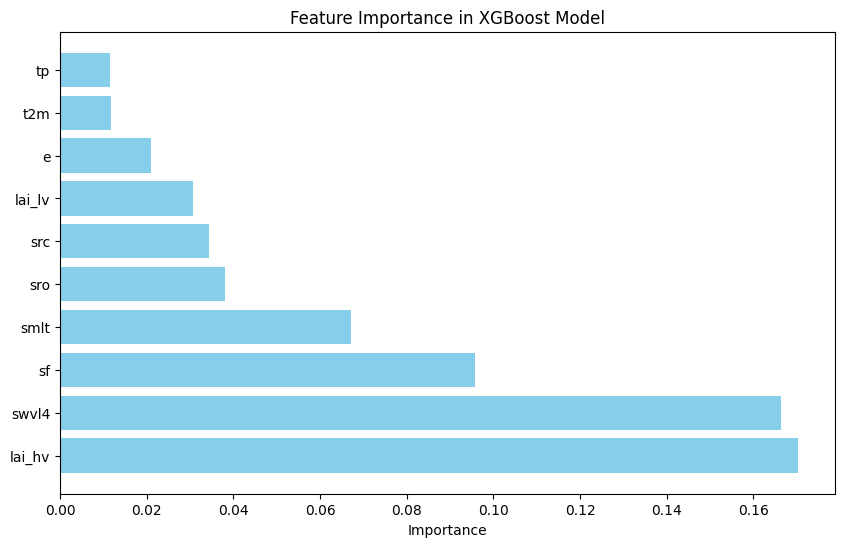

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Assuming XGB_model is your trained XGBoost model and features is a list of feature names

# Specify the features to exclude
exclude_features = ['lat', 'lon', 'months_since_inception']

# Filter out the excluded features
filtered_features = [feature for feature in features if feature not in exclude_features]

# Calculate feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance excluding the specified features
feature_importance_df = pd.DataFrame({
    'Feature': filtered_features,
    'Importance': importances[[features.index(feature) for feature in filtered_features]]
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost Model')
plt.show()


## Model 3 - Catboost Regressor Model


CatBoost Accuracy Metrics:
Mean Squared Error: 1656.4121422394883
Mean Absolute Error: 15.888028539782992
R-squared: 0.7265783894659337


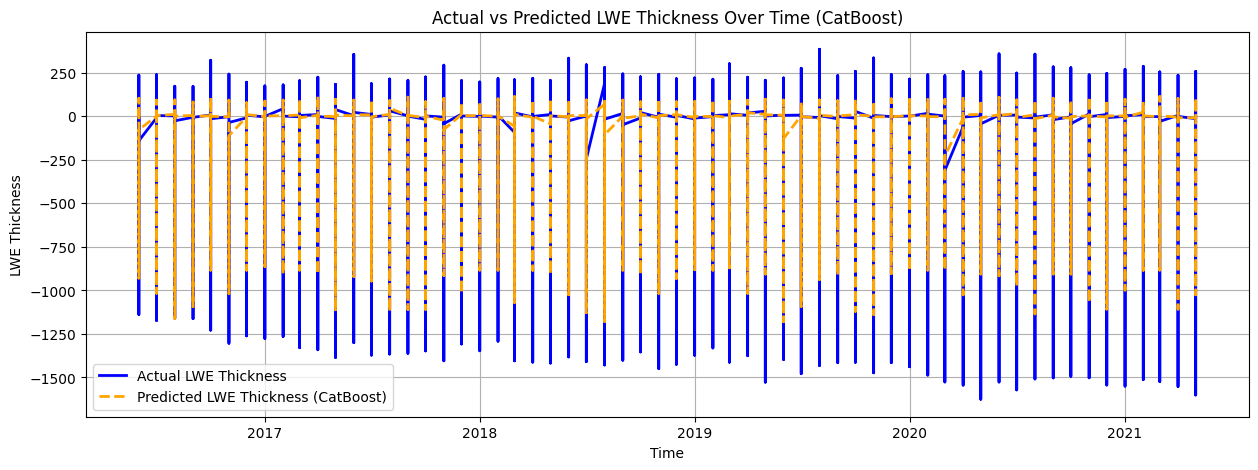

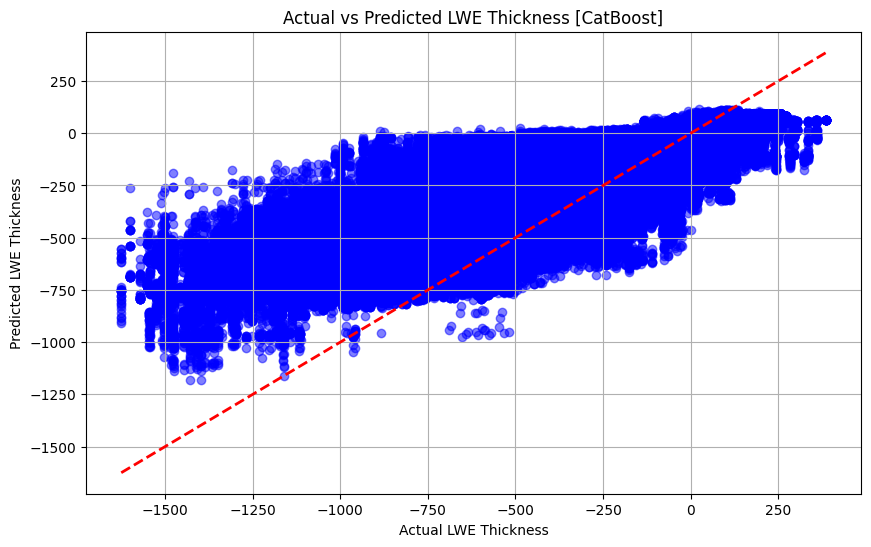

In [4]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Set the inception date
inception_date = df['time'].min()

# Define a function to calculate months since inception
def months_since_inception(date, inception_date):
    return (date.year - inception_date.year) * 12 + (date.month - inception_date.month)

# Apply the function to the 'time' column
df['months_since_inception'] = df['time'].apply(lambda x: months_since_inception(x, inception_date))

# Sort the DataFrame by time
df = df.sort_values(by='time')

# Determine the last date in the data
last_date = df['time'].max()

# Get the date that is 5 years before the last date
five_years_before_last = last_date - pd.DateOffset(years=5)

# Split the data into training
df_train = df[df['time'] <= five_years_before_last]
df_test = df[df['time'] > five_years_before_last]

# Define features and target variable for training and testing
features = ['months_since_inception', 'lat', 'lon','sro', 'smlt', 'sf', 'e', 'tp', 'swvl4', 'lai_lv', 'lai_hv', 't2m', 'src']
X_train = df_train[features]
y_train = df_train['LWE_Thickness']

X_test = df_test[features]
y_test = df_test['LWE_Thickness']

# Initialize and fit the CatBoost model
catboost_model = CatBoostRegressor(iterations=100, random_seed=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_catboost = catboost_model.predict(X_test)

# Evaluate model performance
mse_catboost = mean_squared_error(y_test, predictions_catboost)
mae_catboost = mean_absolute_error(y_test, predictions_catboost)
r2_catboost = r2_score(y_test, predictions_catboost)

# Print accuracy metrics
print("\nCatBoost Accuracy Metrics:")
print(f"Mean Squared Error: {mse_catboost}")
print(f"Mean Absolute Error: {mae_catboost}")
print(f"R-squared: {r2_catboost}")

# Create a DataFrame to compare expected vs predicted values
results_catboost = pd.DataFrame({
    'time': df_test['time'].values,
    'expected': y_test.values,
    'predicted': predictions_catboost
})

# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(results_catboost['time'], results_catboost['expected'], label='Actual LWE Thickness', color='blue', linewidth=2)
plt.plot(results_catboost['time'], results_catboost['predicted'], label='Predicted LWE Thickness (CatBoost)', color='orange', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Actual vs Predicted LWE Thickness Over Time (CatBoost)')
plt.xlabel('Time')
plt.ylabel('LWE Thickness')
plt.legend()
plt.grid()
plt.show()

# Plot actual vs predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_catboost, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual LWE Thickness')
plt.ylabel('Predicted LWE Thickness')
plt.title('Actual vs Predicted LWE Thickness [CatBoost]')
plt.grid()
plt.show()


*   Feature Importance [CatBoost Model]

  Feature  Importance
5   swvl4   12.987991
2      sf    4.471859
7  lai_hv    2.671894
6  lai_lv    1.409642
9     src    1.010452
3       e    0.786210
4      tp    0.220500
1    smlt    0.215947
8     t2m    0.124683
0     sro    0.077540


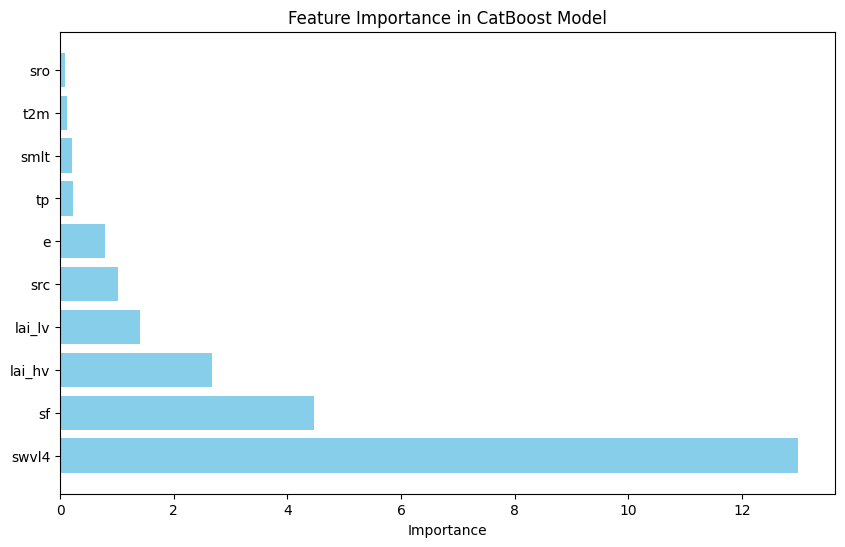

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

# Assuming catboost_model is your trained CatBoost model and features is a list of feature names

# Specify the features to exclude
exclude_features = ['lat', 'lon', 'months_since_inception']

# Filter out the excluded features
filtered_features = [feature for feature in features if feature not in exclude_features]

# Calculate feature importances
importances = catboost_model.get_feature_importance()

# Create a DataFrame for feature importance excluding the specified features
feature_importance_df = pd.DataFrame({
    'Feature': filtered_features,
    'Importance': importances[[features.index(feature) for feature in filtered_features]]
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in CatBoost Model')
plt.show()


## Model 4 - Decision Tree Regressor Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Set the inception date
inception_date = df['time'].min()

# Define a function to calculate months since inception
def months_since_inception(date, inception_date):
    return (date.year - inception_date.year) * 12 + (date.month - inception_date.month)

# Apply the function to the 'time' column
df['months_since_inception'] = df['time'].apply(lambda x: months_since_inception(x, inception_date))

# Sort the DataFrame by time
df = df.sort_values(by='time')

# Determine the last date in the data
last_date = df['time'].max()

# Get the date that is 5 years before the last date
five_years_before_last = last_date - pd.DateOffset(years=5)

# Split the data into training
df_train = df[df['time'] <= five_years_before_last]
df_test = df[df['time'] > five_years_before_last]

# Define features and target variable for training and testing
features = ['months_since_inception', 'lat', 'lon', 'sro', 'smlt', 'sf', 'e', 'tp', 'swvl4', 'lai_lv', 'lai_hv', 't2m', 'src']
X_train = df_train[features]
y_train = df_train['LWE_Thickness']

X_test = df_test[features]
y_test = df_test['LWE_Thickness']

# Initialize and fit the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_dt = dt_model.predict(X_test)

# Evaluate model performance
mse_dt = mean_squared_error(y_test, predictions_dt)
mae_dt = mean_absolute_error(y_test, predictions_dt)
r2_dt = r2_score(y_test, predictions_dt)

# Print accuracy metrics
print("\nDecision Tree Accuracy Metrics:")
print(f"Mean Squared Error: {mse_dt}")
print(f"Mean Absolute Error: {mae_dt}")
print(f"R-squared: {r2_dt}")

# Create a DataFrame to compare expected vs predicted values
results_dt = pd.DataFrame({
    'time': df_test['time'].values,
    'expected': y_test.values,
    'predicted': predictions_dt
})

# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(results_dt['time'], results_dt['expected'], label='Actual LWE Thickness', color='blue', linewidth=2)
plt.plot(results_dt['time'], results_dt['predicted'], label='Predicted LWE Thickness (Decision Tree)', color='orange', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Actual vs Predicted LWE Thickness Over Time (Decision Tree)')
plt.xlabel('Time')
plt.ylabel('LWE Thickness')
plt.legend()
plt.grid()
plt.show()

# Plot actual vs predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_dt, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual LWE Thickness')
plt.ylabel('Predicted LWE Thickness')
plt.title('Actual vs Predicted LWE Thickness [Decision Tree]')
plt.grid()
plt.show()


*   Feature Importance [Decision Tree Model]

  Feature  Importance
5   swvl4    0.136379
2      sf    0.032246
9     src    0.024970
3       e    0.016239
8     t2m    0.014798
7  lai_hv    0.014372
4      tp    0.009473
6  lai_lv    0.006939
0     sro    0.003465
1    smlt    0.002325


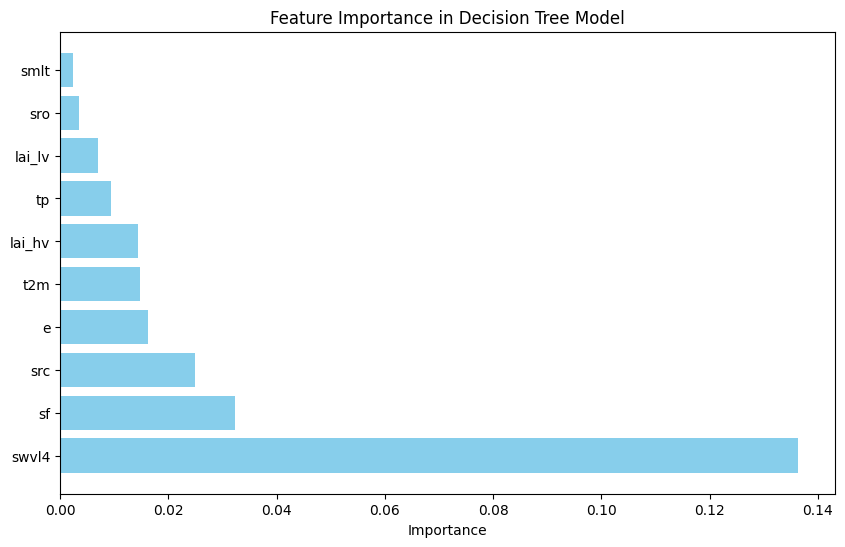

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Assuming dt_model is your trained Decision Tree model and features is a list of feature names

# Specify the features to exclude
exclude_features = ['lat', 'lon', 'months_since_inception']

# Filter out the excluded features
filtered_features = [feature for feature in features if feature not in exclude_features]

# Calculate feature importances
importances = dt_model.feature_importances_

# Create a DataFrame for feature importance excluding the specified features
feature_importance_df = pd.DataFrame({
    'Feature': filtered_features,
    'Importance': importances[[features.index(feature) for feature in filtered_features]]
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Decision Tree Model')
plt.show()


## Model 5 - Dynamic generalised additive model

*   DGAM model was consulted because of the model's ability to account for discrete non-linear values better than the conventional algorithms.



  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Training data range: 2002-01-01 00:00:00 - 2016-05-01 00:00:00
Testing data range: 2016-06-01 00:00:00 - 2021-05-01 00:00:00


100% (10 of 10) |########################| Elapsed Time: 0:54:53 Time:  0:54:53
<ipython-input-3-518f6af57454>:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    930.2741
Link Function:                     IdentityLink Log Likelihood:                              -4298338.1491
Number of Samples:                       598219 AIC:                                          8598538.8465
                                                AICc:                                         8598541.7537
                                                GCV:                                              527.4953
                                                Scale:                                             526.019
                                                Pseudo R-Squared:                                   0.4393
Feature Function                  Lam

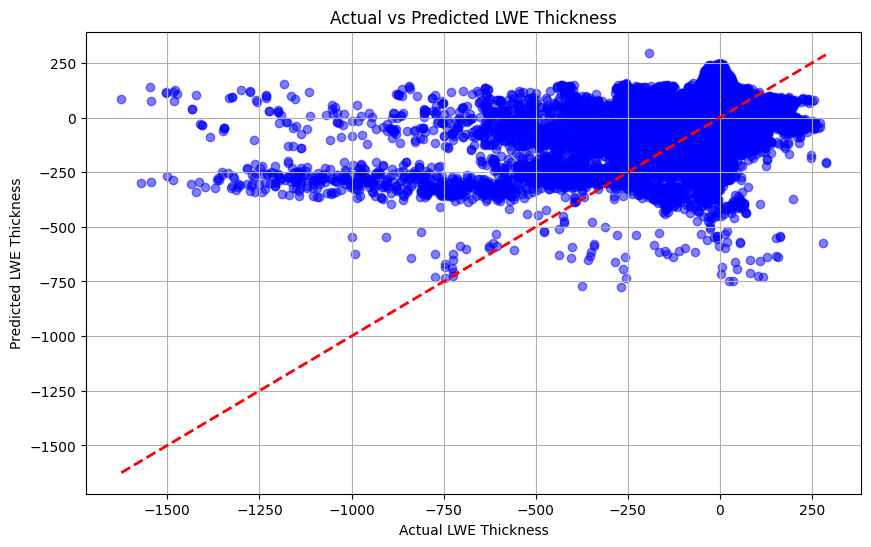

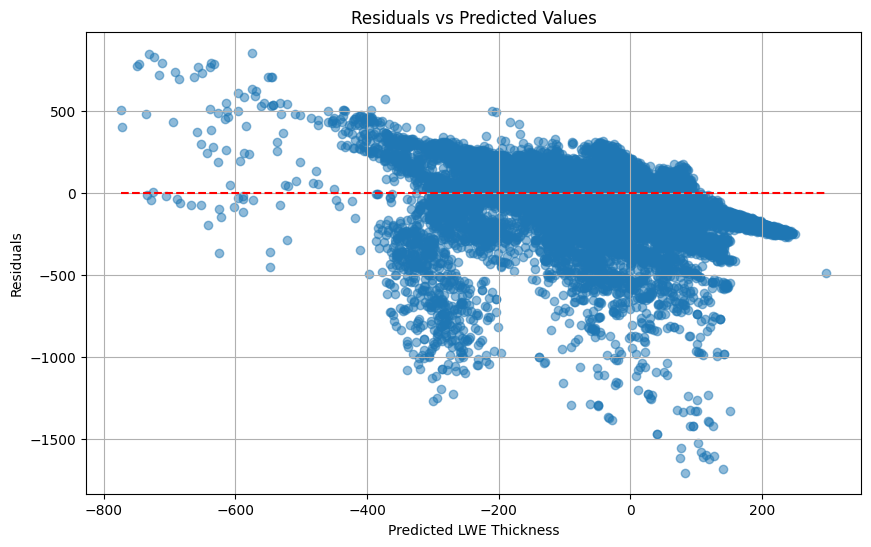

In [3]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, s, te
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Set the inception date
inception_date = df['time'].min()

# Define a function to calculate months since inception
def months_since_inception(date, inception_date):
    return (date.year - inception_date.year) * 12 + (date.month - inception_date.month)

# Apply the function to the 'time' column
df['months_since_inception'] = df['time'].apply(lambda x: months_since_inception(x, inception_date))

# Sort the DataFrame by time
df = df.sort_values(by='time')

# Determine the last date in the data
last_date = df['time'].max()

# Get the date that is 5 years before the last date
five_years_before_last = last_date - pd.DateOffset(years=5)

# Split the data into training (data before 5 years) and testing sets (data from the last 5 years)
df_train = df[df['time'] <= five_years_before_last]
df_test = df[df['time'] > five_years_before_last]

# Check the training and testing data ranges
print(f"Training data range: {df_train['time'].min()} - {df_train['time'].max()}")
print(f"Testing data range: {df_test['time'].min()} - {df_test['time'].max()}")

# Define features and target variable for training and testing
features = ['months_since_inception', 'lat', 'lon', 'sro', 'smlt', 'sf', 'e', 'tp',
            'swvl4', 'lai_lv', 'lai_hv', 't2m', 'src']
X_train = df_train[features]
y_train = df_train['LWE_Thickness']

X_test = df_test[features]
y_test = df_test['LWE_Thickness']

# Fit a dynamic GAM with space-time interaction and exogenous variables
gam = LinearGAM(
    te(0, 1, 2) +  # Space-time interaction for months_since_inception, lat, lon
    s(3) +          # 'sro'
    s(4) +          # 'smlt'
    s(5) +          # 'sf'
    s(6) +          # 'e'
    s(7) +          # 'tp'
    s(8) +          # 'swvl4'
    s(9) +          # 'lai_lv'
    s(10) +         # 'lai_hv'
    s(11) +         # 't2m'
    s(12)           # 'src'
  )

# Define a range of lambda values to test during the grid search
lams = np.logspace(-3, 3, 10)  # Testing lambda values from 0.001 to 1000

# Run cross-validation to find the optimal lambdas
gam.gridsearch(X_train.values, y_train.values, lam=lams)

# Summary of the model after cross-validation
gam.summary()

# Predict on the test data (last 5 years)
predictions = gam.predict(X_test.values)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("\nAccuracy Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Create a DataFrame to compare expected vs predicted values
results = pd.DataFrame({
    'time': df_test['time'].values,
    'lat': df_test['lat'].values,
    'lon': df_test['lon'].values,
    'expected': y_test.values,
    'predicted': predictions
})

# Print the expected vs predicted output as a table
print("\nExpected vs Predicted LWE Thickness (last 5 years):")
print(results.head(40))  # Display the first 40 rows

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual LWE Thickness')
plt.ylabel('Predicted LWE Thickness')
plt.title('Actual vs Predicted LWE Thickness')
plt.grid()
plt.show()

# Plot residuals
residuals = y_test.values - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), colors='r', linestyles='--')
plt.xlabel('Predicted LWE Thickness')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid()
plt.show()


Actual vs Predicted LWE Thickness Over Time (DGAM)

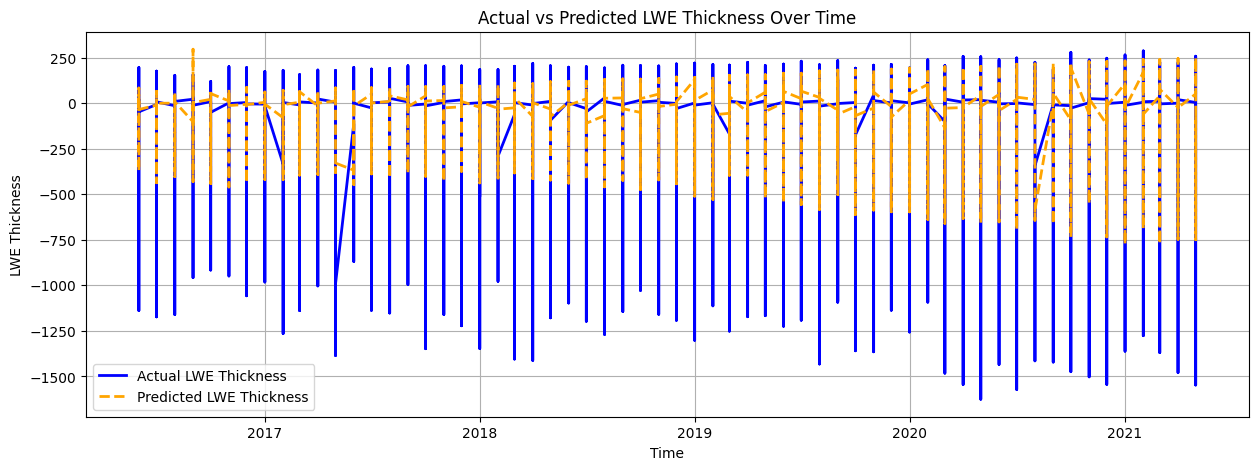

In [15]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values over time
plt.figure(figsize=(15, 5))

# Plot expected values (actual LWE Thickness)
plt.plot(results['time'], results['expected'], label='Actual LWE Thickness', color='blue', linewidth=2)

# Plot predicted values
plt.plot(results['time'], results['predicted'], label='Predicted LWE Thickness', color='orange', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Actual vs Predicted LWE Thickness Over Time')
plt.xlabel('Time')
plt.ylabel('LWE Thickness')
plt.legend()
plt.grid()
plt.show()


# Model Evaluation (Using the Mean Absolute Error)
NB: All metrics have uniform ranking, hence one was selected

*   Model 1 - Random Forest Model: 12.485443485950396
*   Model 2 - XG-Boost Regressor Model: 17.446823120117188
*   Model 3 - CatBoost Regressor Model: 16.267556707427122
*   Model 4 - Decision Tree Regressor Model: 14.066308051846082
*   Model 5 - Dynamic generalised additive Model: 41.77369078197636

This identifies RandomForest as the best performing model with lowest error margin for the forecast analysis

Plot - Model Evaluation

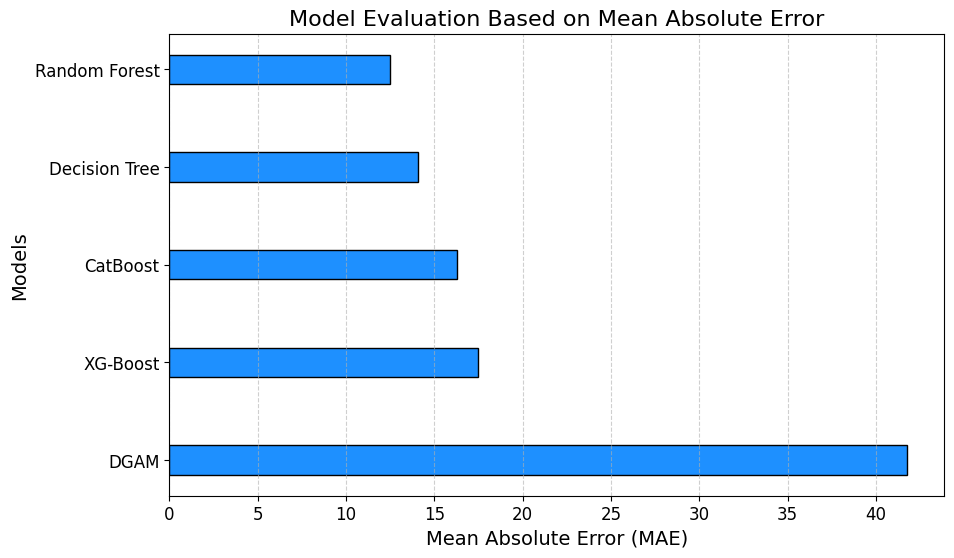

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Model names and their corresponding MAE values
models = ['Random Forest', 'Decision Tree', 'CatBoost', 'XG-Boost', 'DGAM']
mae_values = [12.485443485950396, 14.066308051846082, 16.267556707427122, 17.446823120117188, 41.77369078197636]

# Create a DataFrame for better visualization
mae_df = pd.DataFrame({
    'Model': models,
    'MAE': mae_values
})

# Sort the DataFrame by MAE values (ascending order)
mae_df = mae_df.sort_values(by='MAE', ascending=True)

# Plot the MAE values as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(mae_df['Model'], mae_df['MAE'], color='dodgerblue', edgecolor='black', height=0.3)

# Set bold labels and title
plt.xlabel('Mean Absolute Error (MAE)', fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.title('Model Evaluation Based on Mean Absolute Error', fontsize=16)

# Set grid for better readability
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Make tick labels bolder and larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the best (lowest) MAE at the top
plt.gca().invert_yaxis()

# Display the plot
plt.show()


# Identifying Predictive power of Exogenous Variables

---



1. **[Random Forest] Feature Importance evaluation / feature ablation analysis**

This assesses the impact of each feature on the model's performance by dropping (or ablating) one feature at a time and observing the change in a performance metric—in this case, the R-squared value.

In [40]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# List of exogenous variables
exo_features = ['swvl4', 'lai_lv', 'lai_hv', 't2m', 'src', 'sro', 'smlt', 'sf', 'e', 'tp']

# Initialize and train the Random Forest model using only exogenous features
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train[exo_features], y_train)

# Calculate baseline performance with all exogenous features
baseline_predictions = rf_model.predict(X_test[exo_features])
baseline_r2 = r2_score(y_test, baseline_predictions)

# Test model performance by dropping each exogenous feature
for feature in exo_features:
    X_train_drop = X_train[exo_features].drop(columns=[feature])
    X_test_drop = X_test[exo_features].drop(columns=[feature])

    # Train a new Random Forest model without the current feature
    rf_drop = RandomForestRegressor(random_state=42)
    rf_drop.fit(X_train_drop, y_train)

    # Predict and calculate performance
    predictions_drop = rf_drop.predict(X_test_drop)
    r2_drop = r2_score(y_test, predictions_drop)

    print(f"Dropping {feature}: R-squared dropped from {baseline_r2:.4f} to {r2_drop:.4f}")


Dropping swvl4: R-squared dropped from 0.1683 to 0.1080
Dropping lai_lv: R-squared dropped from 0.1683 to 0.1591
Dropping lai_hv: R-squared dropped from 0.1683 to 0.1625
Dropping t2m: R-squared dropped from 0.1683 to 0.1653
Dropping src: R-squared dropped from 0.1683 to 0.1549
Dropping sro: R-squared dropped from 0.1683 to 0.1683
Dropping smlt: R-squared dropped from 0.1683 to 0.1683
Dropping sf: R-squared dropped from 0.1683 to 0.1778
Dropping e: R-squared dropped from 0.1683 to 0.1538
Dropping tp: R-squared dropped from 0.1683 to 0.1691


2. **[DGAM] A. Feature Sensitivity Test**

To understand and assess how changes in the exogenous features impact model predictions
NB: high feature sensitivity indicates that exogenous varable has a significant influence on the model's predictions. The large sensitivity value suggests that changes in this feature result in considerable changes in the output of the model

In [10]:
# Calculate sensitivity (change in predictions) for each feature
sensitivity = {}

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue  # Skip intercept term

    X_test_grid = gam.generate_X_grid(term=i)

    # Predict with and without a small perturbation in the feature
    base_predictions = gam.predict(X_test_grid)
    perturbed_X_test = X_test_grid.copy()
    perturbed_X_test[:, i] += 1e-4  # Small perturbation
    perturbed_predictions = gam.predict(perturbed_X_test)

    # Calculate sensitivity as the mean absolute change in predictions
    sensitivity[i] = np.mean(np.abs(perturbed_predictions - base_predictions))

# Sort features by sensitivity
sorted_sensitivity = sorted(sensitivity.items(), key=lambda x: x[1], reverse=True)

# List of feature names corresponding to the model
feature_names = ['months_since_inception', 'lat', 'lon', 'sro', 'smlt', 'sf', 'e', 'tp', 'swvl4', 'lai_lv', 'lai_hv', 't2m', 'src']

print("Feature sensitivities:")
for i, sens in sorted_sensitivity:
    print(f"Feature '{feature_names[i]}': Sensitivity = {sens:.4f}")


Feature sensitivities:
Feature 6: Sensitivity = 12.7475
Feature 3: Sensitivity = 0.2190
Feature 5: Sensitivity = 0.2091
Feature 4: Sensitivity = 0.1418
Feature 7: Sensitivity = 0.0472
Feature 8: Sensitivity = 0.0330
Feature 10: Sensitivity = 0.0013
Feature 9: Sensitivity = 0.0007
Feature 2: Sensitivity = 0.0001
Feature 0: Sensitivity = 0.0001
Feature 1: Sensitivity = 0.0000


3. **[DGAM] Feature Importance evaluation / feature ablation analysis**



In [11]:
from sklearn.metrics import r2_score

# Calculate baseline performance with all features
baseline_predictions = gam.predict(X_test.values)
baseline_r2 = r2_score(y_test.values, baseline_predictions)

# Test model performance by dropping each feature
for i, feature in enumerate(features):
    # Drop feature i
    X_train_drop = np.delete(X_train.values, i, axis=1)
    X_test_drop = np.delete(X_test.values, i, axis=1)

    # Train a new GAM without the feature
    gam_drop = LinearGAM().fit(X_train_drop, y_train.values)

    # Predict and calculate performance
    predictions_drop = gam_drop.predict(X_test_drop)
    r2_drop = r2_score(y_test.values, predictions_drop)

    # Report the performance drop
    print(f"Dropping {feature}: R-squared dropped from {baseline_r2:.4f} to {r2_drop:.4f}")


Dropping months_since_inception: R-squared dropped from -0.0691 to 0.0865
Dropping lat: R-squared dropped from -0.0691 to -0.5496
Dropping lon: R-squared dropped from -0.0691 to -0.5814
Dropping sro: R-squared dropped from -0.0691 to -0.5500
Dropping smlt: R-squared dropped from -0.0691 to -0.6177
Dropping sf: R-squared dropped from -0.0691 to -0.3895
Dropping e: R-squared dropped from -0.0691 to -0.6191
Dropping tp: R-squared dropped from -0.0691 to -0.4953
Dropping swvl4: R-squared dropped from -0.0691 to -0.6398
Dropping lai_lv: R-squared dropped from -0.0691 to -0.5608
Dropping lai_hv: R-squared dropped from -0.0691 to -0.4665
Dropping t2m: R-squared dropped from -0.0691 to -0.5539
Dropping src: R-squared dropped from -0.0691 to -0.4608


## Test: Performance of model after removing non-essential exogenous variables


---


*   These are variables with negligible or negative impact (Overfitting model) on metric score when dropped (sf, smlt, sro, tp)


Random Forest Accuracy Metrics:
Mean Squared Error: 888.8722212547024
Mean Absolute Error: 11.83199169589771
R-squared: 0.8448201754551269


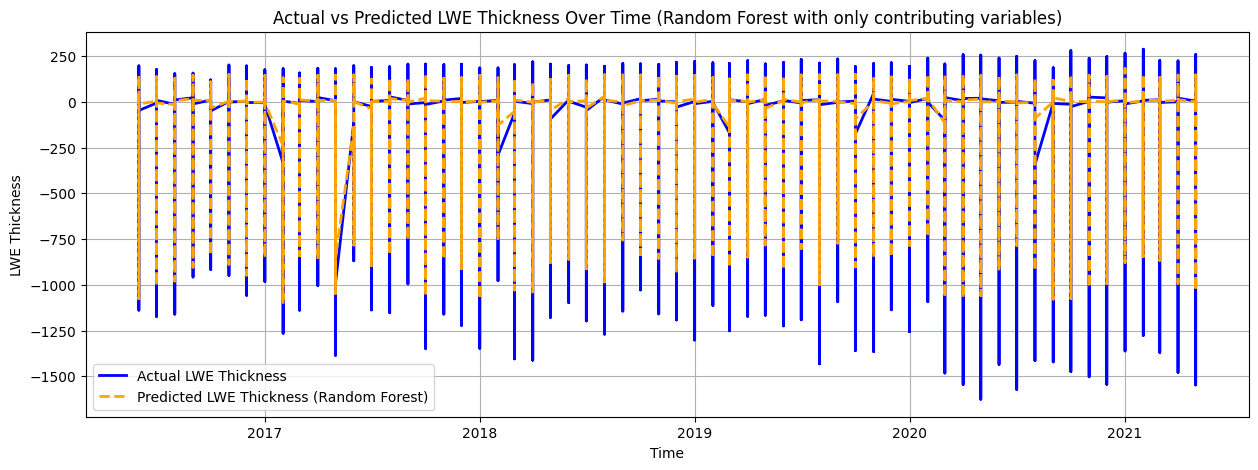

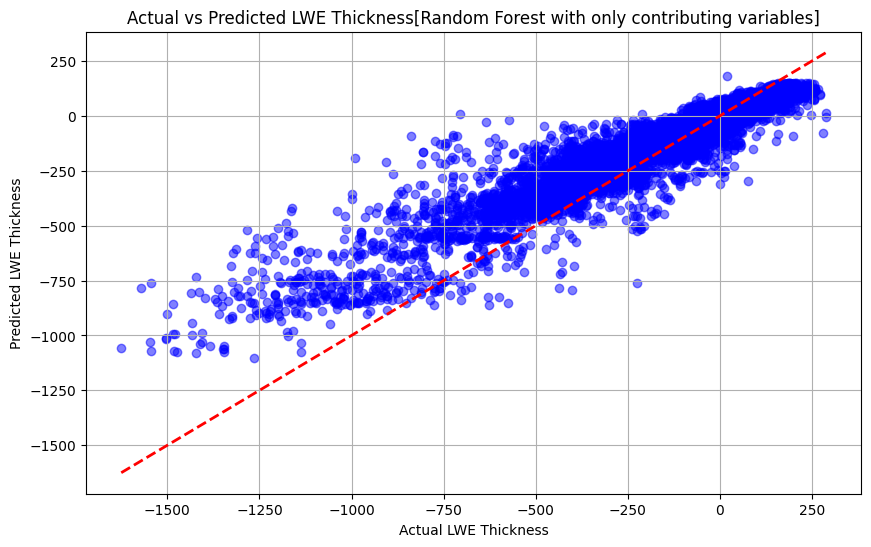

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Set the inception date
inception_date = df['time'].min()

# Define a function to calculate months since inception
def months_since_inception(date, inception_date):
    return (date.year - inception_date.year) * 12 + (date.month - inception_date.month)

# Apply the function to the 'time' column
df['months_since_inception'] = df['time'].apply(lambda x: months_since_inception(x, inception_date))

# Sort the DataFrame by time
df = df.sort_values(by='time')

# Determine the last date in the data
last_date = df['time'].max()

# Get the date that is 5 years before the last date
five_years_before_last = last_date - pd.DateOffset(years=5)

# Split the data into training
df_train = df[df['time'] <= five_years_before_last]
df_test = df[df['time'] > five_years_before_last]

# Define features and target variable for training and testing
features = ['months_since_inception', 'lat', 'lon', 'e', 'swvl4', 'lai_lv', 'lai_hv', 't2m', 'src']
X_train = df_train[features]
y_train = df_train['LWE_Thickness']

X_test = df_test[features]
y_test = df_test['LWE_Thickness']

# Initialize and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_rf = rf_model.predict(X_test)

# Evaluate model performance
mse_rf = mean_squared_error(y_test, predictions_rf)
mae_rf = mean_absolute_error(y_test, predictions_rf)
r2_rf = r2_score(y_test, predictions_rf)

# Print accuracy metrics
print("\nRandom Forest Accuracy Metrics:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R-squared: {r2_rf}")

# Create a DataFrame to compare expected vs predicted values
results_rf = pd.DataFrame({
    'time': df_test['time'].values,
    'expected': y_test.values,
    'predicted': predictions_rf
})

# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(results_rf['time'], results_rf['expected'], label='Actual LWE Thickness', color='blue', linewidth=2)
plt.plot(results_rf['time'], results_rf['predicted'], label='Predicted LWE Thickness (Random Forest)', color='orange', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Actual vs Predicted LWE Thickness Over Time (Random Forest with only contributing variables)')
plt.xlabel('Time')
plt.ylabel('LWE Thickness')
plt.legend()
plt.grid()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_rf, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual LWE Thickness')
plt.ylabel('Predicted LWE Thickness')
plt.title('Actual vs Predicted LWE Thickness[Random Forest with only contributing variables]')
plt.grid()
plt.show()


Feature Importance [Random Forest Model with only contributing variables]

# **Findings**


---



---




### **Top Exogenous variables**
Based on the Feature sensitivity analysis and Feature ablation analysis using the best performing model, RandomForest and DGAM, Soil Water Volumetric Level 4 (swvl4) is identified as the top exogenous variable with the highest predictive power for predicting LWE Thickness. Removing swvl4 caused a sharp decrease in R-squared from 0.1683 to 0.1080 (0.0603). This indicates that this feature is crucial for the model's accuracy.

Also using DGAM, swvl4 was represented to have the highest feature sensitivity of 12.7475 (swvl4 = Feature 6), and the lowest drop of R-squared value of (0.5707).
The feature Importance analysis of all models points to swvl4 having the most impact on model outcome

### Model - Random Forest Model with only contributing Exogenous variables: 11.83199169589771
After exogenous variables with negligible impact or overfitting consequences were identified and filtered out (sf, smlt, sro, tp) following the variable ranking, performance of model improved (MAE dropped from 12.485443485950396 to 11.83199169589771), and swvl4 still ranked the most significant exogenous variables


## Predictive Power ranking of Exogenous variables using RandomForest
1. swvl4: R-squared dropped from 0.1683 to 0.1080 → most important
2. e: R-squared dropped from 0.1683 to 0.1538
3. src: R-squared dropped from 0.1683 to 0.1549
4. lai_lv: R-squared dropped from 0.1683 to 0.1591
5. lai_hv: R-squared dropped from 0.1683 to 0.1625
6. t2m: R-squared dropped from 0.1683 to 0.1653
7. tp: R-squared increased slightly from 0.1683 to 0.1691 → minimal impact
8. sro: No change, R-squared stayed at 0.1683 → no impact
9. smlt: No change, R-squared stayed at 0.1683 → no impact
10. sf: R-squared increased from 0.1683 to 0.1778 → possibly a noisy feature

## Predictive Power ranking of Exogenous variables using DGAM

1. swvl4: R-squared dropped from -0.0691 to -0.6398 → largest drop (most predictive power)
2. e: R-squared dropped from -0.0691 to -0.6191
3. smlt: R-squared dropped from -0.0691 to -0.6177
4. lai_lv: R-squared dropped from -0.0691 to -0.5608
5. t2m: R-squared dropped from -0.0691 to -0.5539
6. sro: R-squared dropped from -0.0691 to -0.5500
7. sf: R-squared dropped from -0.0691 to -0.3895
8. tp: R-squared dropped from -0.0691 to -0.4953
9. lai_hv: R-squared dropped from -0.0691 to -0.4665
10. src: R-squared dropped from -0.0691 to -0.4608



Plot of Predictive Power ranking 1

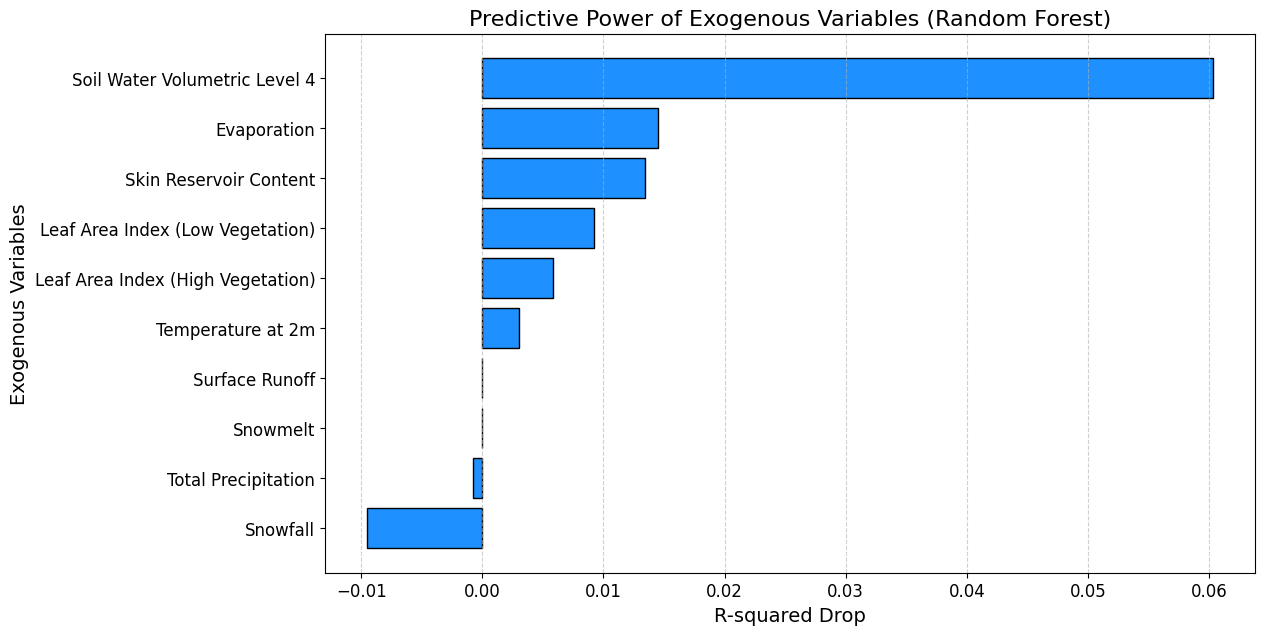

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Baseline R-squared with all features
baseline_r2 = 0.1683

# R-squared values after dropping each feature
r2_values = {
    'swvl4': 0.1080,
    'e': 0.1538,
    'src': 0.1549,
    'lai_lv': 0.1591,
    'lai_hv': 0.1625,
    't2m': 0.1653,
    'tp': 0.1691,
    'sro': 0.1683,
    'smlt': 0.1683,
    'sf': 0.1778
}

# Mapping of variable abbreviations to actual names
variable_names = {
    'swvl4': 'Soil Water Volumetric Level 4',
    'e': 'Evaporation',
    'src': 'Skin Reservoir Content',
    'lai_lv': 'Leaf Area Index (Low Vegetation)',
    'lai_hv': 'Leaf Area Index (High Vegetation)',
    't2m': 'Temperature at 2m',
    'tp': 'Total Precipitation',
    'sro': 'Surface Runoff',
    'smlt': 'Snowmelt',
    'sf': 'Snowfall'
}

# Calculate the R-squared differences (impact of dropping the feature)
r2_diff = {feature: baseline_r2 - r2 for feature, r2 in r2_values.items()}

# Create a DataFrame for better visualization
r2_diff_df = pd.DataFrame(list(r2_diff.items()), columns=['Feature', 'R-squared Drop'])
r2_diff_df['Variable Name'] = r2_diff_df['Feature'].map(variable_names)  # Map the variable names
r2_diff_df = r2_diff_df.sort_values(by='R-squared Drop', ascending=False)

# Plot the R-squared drop as a bar chart
plt.figure(figsize=(12, 7))  # Increase the figure size
plt.barh(r2_diff_df['Variable Name'], r2_diff_df['R-squared Drop'], color='dodgerblue', edgecolor='black', height=0.8)  # Thicker bars with border

# Set bold labels and title
plt.xlabel('R-squared Drop', fontsize=14)
plt.ylabel('Exogenous Variables', fontsize=14)
plt.title('Predictive Power of Exogenous Variables (Random Forest)', fontsize=16)

# Set grid for better readability
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Make tick labels bolder and larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the largest drop at the top
plt.gca().invert_yaxis()

plt.show()


Plot of Predictive Power ranking 2

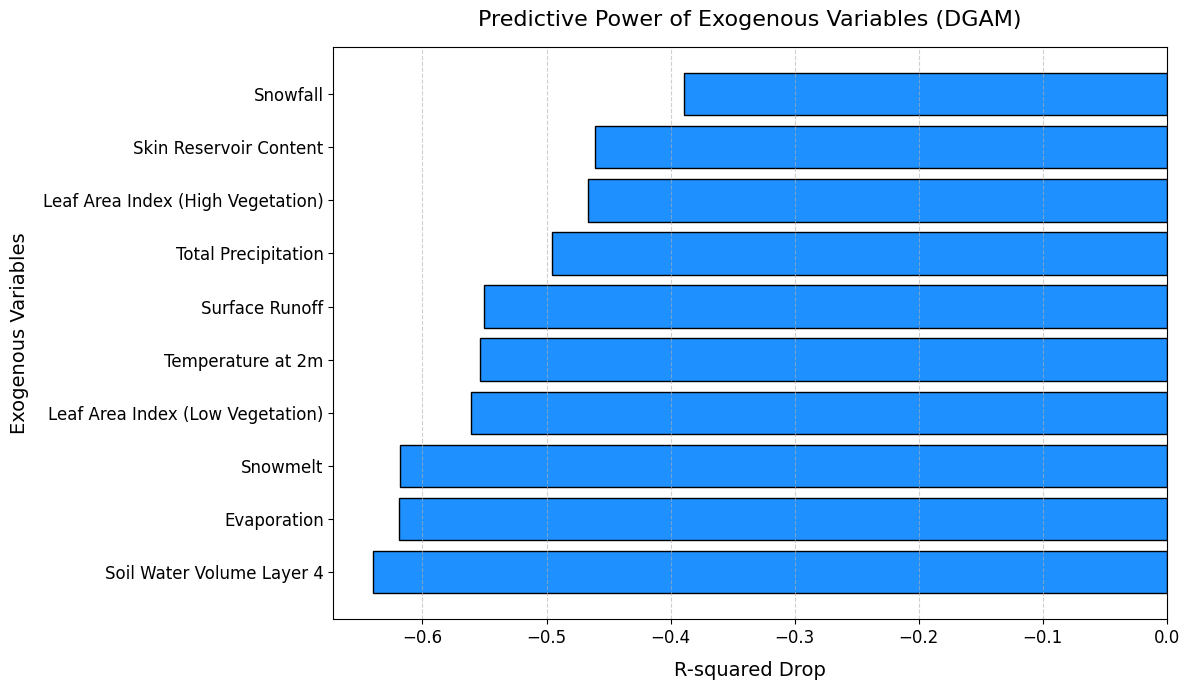

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# R-squared drop values after dropping each exogenous variable
r2_values = {
    'Soil Water Volume Layer 4': -0.6398,
    'Evaporation': -0.6191,
    'Snowmelt': -0.6177,
    'Leaf Area Index (Low Vegetation)': -0.5608,
    'Temperature at 2m': -0.5539,
    'Surface Runoff': -0.5500,
    'Total Precipitation': -0.4953,
    'Leaf Area Index (High Vegetation)': -0.4665,
    'Skin Reservoir Content': -0.4608,
    'Snowfall': -0.3895
}

# Create a DataFrame for better visualization
r2_df = pd.DataFrame(list(r2_values.items()), columns=['Exogenous Variable', 'R-squared Drop'])
r2_df = r2_df.sort_values(by='R-squared Drop', ascending=False)

# Plot the R-squared drop as a horizontal bar chart
plt.figure(figsize=(12, 7))  # Set figure size
plt.barh(r2_df['Exogenous Variable'], r2_df['R-squared Drop'], color='dodgerblue', edgecolor='black')

# Set bold labels and title
plt.xlabel('R-squared Drop', fontsize=14, labelpad=10)
plt.ylabel('Exogenous Variables', fontsize=14, labelpad=10)
plt.title('Predictive Power of Exogenous Variables (DGAM)', fontsize=16, pad=15)

# Set grid for better readability
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Make tick labels bolder and larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the largest drop at the top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()


Plot of Predictive Power ranking 3

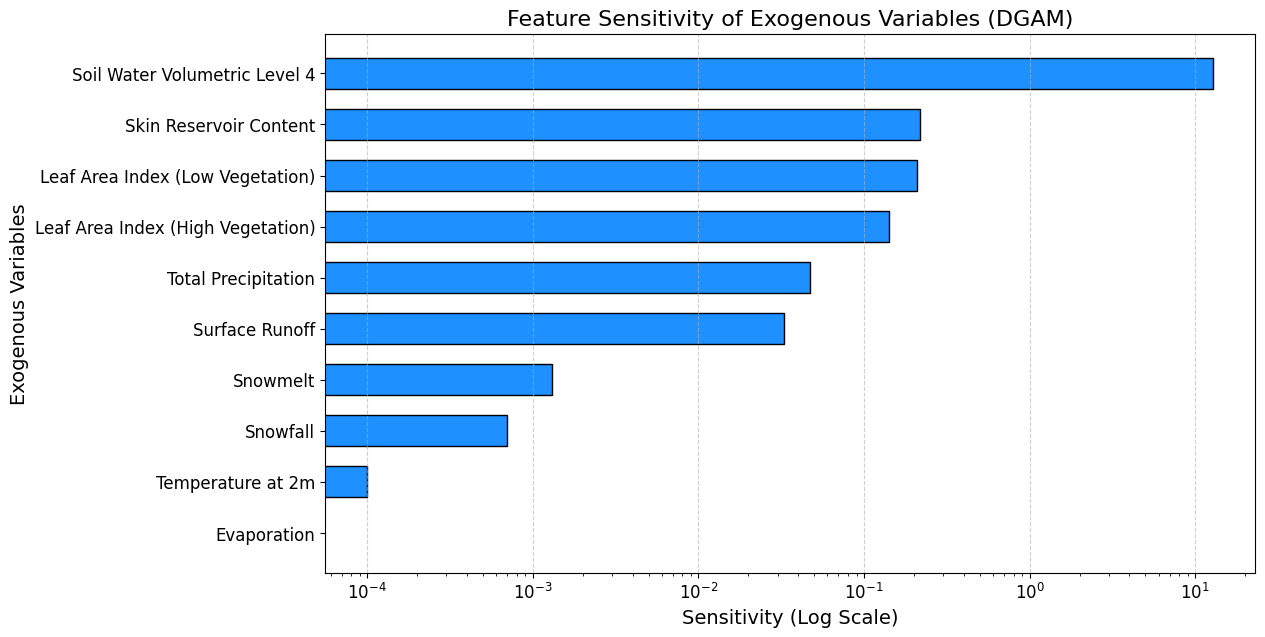

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Feature sensitivities
sensitivity_values = {
    'swvl4': 12.7475,  # Original value for swvl4
    'e': 0.0000,
    'src': 0.2190,
    'lai_lv': 0.2091,
    'lai_hv': 0.1418,
    't2m': 0.0001,
    'tp': 0.0472,
    'sro': 0.0330,
    'smlt': 0.0013,
    'sf': 0.0007
}

# Mapping of variable abbreviations to actual names
variable_names = {
    'swvl4': 'Soil Water Volumetric Level 4',
    'e': 'Evaporation',
    'src': 'Skin Reservoir Content',
    'lai_lv': 'Leaf Area Index (Low Vegetation)',
    'lai_hv': 'Leaf Area Index (High Vegetation)',
    't2m': 'Temperature at 2m',
    'tp': 'Total Precipitation',
    'sro': 'Surface Runoff',
    'smlt': 'Snowmelt',
    'sf': 'Snowfall'
}

# Create a DataFrame for sensitivity values
sensitivity_df = pd.DataFrame(list(sensitivity_values.items()), columns=['Feature', 'Sensitivity'])
sensitivity_df['Variable Name'] = sensitivity_df['Feature'].map(variable_names)

# Sort the DataFrame by sensitivity
sensitivity_df = sensitivity_df.sort_values(by='Sensitivity', ascending=False)

# Plotting
plt.figure(figsize=(12, 7))
plt.barh(sensitivity_df['Variable Name'], sensitivity_df['Sensitivity'], color='dodgerblue', edgecolor='black', height=0.6)

# Set bold labels and title
plt.xlabel('Sensitivity (Log Scale)', fontsize=14)
plt.ylabel('Exogenous Variables', fontsize=14)
plt.title('Feature Sensitivity of Exogenous Variables (DGAM)', fontsize=16)

# Set a logarithmic scale for the x-axis
plt.xscale('log')

# Set grid for better readability
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Make tick labels bolder and larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the largest sensitivity at the top
plt.gca().invert_yaxis()

# Show plot
plt.show()


Reactive Plot of Predictive Power ranking

In [3]:
import pandas as pd
import plotly.express as px

# Baseline R-squared with all features
baseline_r2 = 0.1683

# R-squared values after dropping each feature
r2_values = {
    'swvl4': 0.1080,
    'e': 0.1538,
    'src': 0.1549,
    'lai_lv': 0.1591,
    'lai_hv': 0.1625,
    't2m': 0.1653,
    'tp': 0.1691,
    'sro': 0.1683,
    'smlt': 0.1683,
    'sf': 0.1778
}

# Mapping of variable abbreviations to full names and descriptions
variable_info = {
    'swvl4': {
        'full_name': 'Soil Water Volumetric Level 4',
        'description': 'The volumetric water content in the fourth layer of soil.',
        'units': 'm³/m³ (volume fraction)'
    },
    'e': {
        'full_name': 'Evaporation',
        'description': 'Total amount of water evaporated from the surface (including transpiration from plants).',
        'units': 'm (meters)'
    },
    'src': {
        'full_name': 'Skin Reservoir Content',
        'description': 'Refers to the water content at the skin level (topmost surface)',
        'units': '(m of water equivalent)'
    },
    'lai_lv': {
        'full_name': 'Leaf Area Index Low Vegetation',
        'description': 'The one-sided green leaf area per unit ground area for low vegetation (e.g., grasslands).',
        'units': 'dimensionless (m²/m²)'
    },
    'lai_hv': {
        'full_name': 'Leaf Area Index High Vegetation',
        'description': 'The one-sided green leaf area per unit ground area for high vegetation (e.g., forests).',
        'units': 'dimensionless (m²/m²)'
    },
    't2m': {
        'full_name': '2-meter Temperature',
        'description': 'Air temperature at 2 meters above the surface.',
        'units': 'K (Kelvin)'
    },
    'tp': {
        'full_name': 'Total Precipitation',
        'description': 'Sum of liquid and solid precipitation reaching the ground (rain, snow, etc.).',
        'units': 'm (meters)'
    },
    'sro': {
        'full_name': 'Surface Runoff',
        'description': 'Amount of water running off the surface, usually due to precipitation that doesn\'t infiltrate the ground.',
        'units': 'm (meters)'
    },
    'smlt': {
        'full_name': 'Snowmelt',
        'description': 'Rate of melting snow contributing to surface runoff or groundwater.',
        'units': 'kg/m² (kilograms per square meter)'
    },
    'sf': {
        'full_name': 'Snowfall',
        'description': 'The accumulated amount of snow that falls to the surface.',
        'units': 'm (meters)'
    }
}

# Calculate the R-squared differences (impact of dropping the feature)
r2_diff = {feature: baseline_r2 - r2 for feature, r2 in r2_values.items()}

# Create a DataFrame for better visualization
r2_diff_df = pd.DataFrame(list(r2_diff.items()), columns=['Feature', 'R-squared Drop'])
r2_diff_df['Full Name'] = r2_diff_df['Feature'].map(lambda x: variable_info[x]['full_name'])
r2_diff_df['Units'] = r2_diff_df['Feature'].map(lambda x: variable_info[x]['units'])

# Create the plot with Plotly
fig = px.bar(
    r2_diff_df,
    x='R-squared Drop',
    y='Full Name',
    text='R-squared Drop',
    orientation='h',
    title='Predictive Power of Exogenous Variables (Random Forest)',
    hover_name='Full Name',
    hover_data={'Units': True},
    color='R-squared Drop'
)

# Update layout for better appearance
fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(
    xaxis_title='R-squared Drop',
    yaxis_title='Exogenous Variables',
    title_font=dict(size=24),
    title_x=0.5,  # Center the title
    template='plotly_white'
)

# Show the figure
fig.show()
